In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

MODEL_NAME = "gpt-3.5-turbo"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    # Always use a fixed embedding model to avoid dimensionality mismatch
    embedding_model = "text-embedding-3-small"  # or "text-embedding-ada-002" if you prefer
    embd = OpenAIEmbeddings(model=embedding_model)

    # If the persisted file exists, delete it to force rebuild if the embedding model changes
    if os.path.exists(persist_path):
        try:
            os.remove(persist_path)
        except Exception as e:
            print(f"Could not remove old vectorstore: {e}")

    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jaind\OneDrive\Documents\Study Material\College\Sem 3\Introduction to LLM\Projects\intro-to-langsmith\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching pages: 100%|##########| 197/197 [00:42<00:00,  4.59it/s]



In [3]:
from langsmith import evaluate, Client
from tqdm.auto import tqdm

tqdm().disable = True

client = Client()
dataset_name = "barcelona_data"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(str(outputs["output"])) < 1.5 * len(str(reference_outputs["output"]))
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    result = langsmith_rag(inputs["question"])
    # Ensure output is always a string
    return {"output": str(result)}

evaluate(
    target_function,
    data=list(client.list_examples(dataset_name=dataset_name)),  # Ensure data is a list, not a generator
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

0it [00:00, ?it/s]

View the evaluation results for experiment: 'gpt-4o-891c6657' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=56ae9c9f-c349-4424-8969-e14fd9c6550b




30it [00:41,  1.38s/it]



,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,I don't know the answer to that question.,None,It influenced a generation of positional play ...,1,1.284959,12c846c9-6819-4420-b0c5-1f5766663411,dc67297d-b738-4f2a-911d-11e2521fa168
1,Who scored for Barcelona in the 2009 Champions...,I don't know the answer to that question.,None,Samuel Eto’o opened the scoring and Lionel Mes...,1,1.121861,165a9264-a137-47bd-84c7-6867bc83ba8f,776dcb72-4cb5-4892-9ecc-139d2474e38b
2,How did Guardiola integrate Busquets during th...,I don't have any information on how Guardiola ...,None,Guardiola promoted Sergio Busquets into the fi...,1,1.093689,2d4cdcdb-e142-493b-9e35-42863b09a7b3,3886dc16-9af3-422c-a684-f89ae07b8154
3,What is FC Barcelona’s sextuple in one paragraph?,I don't know the answer to that question.,None,FC Barcelona’s sextuple refers to winning six ...,1,1.641158,2f9db0ae-6dba-4358-b627-990672b422b3,7a0b3a7d-a20f-4ffa-9dc4-a8bb3257b220
4,Summarize Messi’s impact during the sextuple y...,"During the sextuple year, Lionel Messi had a s...",None,Messi delivered decisive goals and chance crea...,0,1.711109,3a3cedc4-d0e3-4fdc-8f02-d60abcf40ccc,6612f150-cde7-41fc-9fd0-6a06c51d724c
5,Who were Barcelona’s typical midfield three in...,I don't know the answer to that question based...,None,"Xavi Hernández, Andrés Iniesta, and Sergio Bus...",1,1.263191,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,7953a58f-df50-4d2b-b310-5adc7fd18ea6
6,What tactical identity defined Barcelona’s sex...,I don't know the answer to that question.,None,"Positional play with high pressing, quick circ...",1,1.585318,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,d4e0ed37-13a7-4c3d-8d4c-2f1694efdc95
7,What role did La Masia graduates play in the s...,I don't know the answer to that question.,None,"La Masia graduates like Messi, Xavi, Iniesta, ...",1,1.091609,76c7a425-06c9-4278-810e-a6cce027b0e0,4795c9a3-7699-4d11-962f-ab3c0934a010
8,Name three key players central to the sextuple...,"I'm sorry, I don't know the answer to that que...",None,"Lionel Messi, Xavi Hernández, and Andrés Inies...",1,1.300555,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,a8432892-e3fd-4f60-ab63-59bd480c474f
9,What is the difference between a treble and a ...,I don't know the answer to that question.,None,A treble is three major trophies in a season (...,1,1.317477,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,0b514a39-c632-4311-9caa-3495e1c2606b


In [4]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    result = langsmith_rag(inputs["question"])
    # Ensure output is always a string
    return {"output": str(result)}

evaluate(
    target_function,
    data=list(client.list_examples(dataset_name=dataset_name)),  # Ensure data is a list, not a generator
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-2224302e' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=ddabb16b-4ad4-42c8-96bb-72ed8591f53f




30it [00:40,  1.35s/it]
30it [00:40,  1.35s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,I don't know.,None,It influenced a generation of positional play ...,1,1.618059,12c846c9-6819-4420-b0c5-1f5766663411,c2d82122-90ec-40b7-a26d-70a17a9ad34e
1,Who scored for Barcelona in the 2009 Champions...,I don't know.,None,Samuel Eto’o opened the scoring and Lionel Mes...,1,1.190650,165a9264-a137-47bd-84c7-6867bc83ba8f,32f14cd4-dcf7-4729-902a-67368a9bf596
2,How did Guardiola integrate Busquets during th...,I don't know the answer to that question.,None,Guardiola promoted Sergio Busquets into the fi...,1,1.099280,2d4cdcdb-e142-493b-9e35-42863b09a7b3,c9683bf0-06c2-459e-b9d5-2ec06f127e1e
3,What is FC Barcelona’s sextuple in one paragraph?,FC Barcelona's sextuple refers to their histor...,None,FC Barcelona’s sextuple refers to winning six ...,1,2.184524,2f9db0ae-6dba-4358-b627-990672b422b3,f1858a2a-120a-410d-8fd3-35e9433c523e
4,Summarize Messi’s impact during the sextuple y...,"In the sextuple year, Messi had a significant ...",None,Messi delivered decisive goals and chance crea...,1,1.493346,3a3cedc4-d0e3-4fdc-8f02-d60abcf40ccc,76f7c70c-9265-45c2-9e42-b44e3ae66a72
5,Who were Barcelona’s typical midfield three in...,I don't know the answer to that question based...,None,"Xavi Hernández, Andrés Iniesta, and Sergio Bus...",1,1.223723,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,99714d91-2a45-4e12-8a6b-575effac2046
6,What tactical identity defined Barcelona’s sex...,I don't know the answer to that question.,None,"Positional play with high pressing, quick circ...",1,1.072409,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,bfe7c3d9-1c9a-4f5e-9790-04beca9671e6
7,What role did La Masia graduates play in the s...,I don't know the answer to that question.,None,"La Masia graduates like Messi, Xavi, Iniesta, ...",1,1.334185,76c7a425-06c9-4278-810e-a6cce027b0e0,f2b9d603-28e9-4426-8c42-fda8f631e8dd
8,Name three key players central to the sextuple...,I don't know the answer to this question based...,None,"Lionel Messi, Xavi Hernández, and Andrés Inies...",1,1.352508,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,f3862a2e-9cd5-4dba-9fa3-ee900c577319
9,What is the difference between a treble and a ...,I don't know the answer to that question.,None,A treble is three major trophies in a season (...,1,1.351959,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,a6295671-35ee-4cab-b733-33b74ab25a9a


In [5]:
evaluate(
    target_function,
    data=list(client.list_examples(
        dataset_name=dataset_name,
        example_ids=[   # We pass in a specific list of example_ids
            "12c846c9-6819-4420-b0c5-1f5766663411",
            "76c7a425-06c9-4278-810e-a6cce027b0e0",
            "987eca78-d74d-4270-833b-69fa8b1d0e99"
        ]
    )),
    evaluators=[is_concise_enough],
    experiment_prefix="three specific example ids"
 )

View the evaluation results for experiment: 'three specific example ids-087b4e38' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=04ae1964-6b25-4e61-9559-9be4a7d16c9e




3it [00:04,  1.44s/it]
3it [00:04,  1.44s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What was the broader legacy of Barcelona’s 200...,I don't know.,None,It influenced a generation of positional play ...,1,1.180731,12c846c9-6819-4420-b0c5-1f5766663411,fc3bd107-327d-46cf-9807-ff9a01e914cc
1,What role did La Masia graduates play in the s...,I don't know the specific role La Masia gradua...,None,"La Masia graduates like Messi, Xavi, Iniesta, ...",1,1.261202,76c7a425-06c9-4278-810e-a6cce027b0e0,ad3b165d-f6df-49aa-862d-4d24684bd93a
2,List the six trophies in a single comma-separa...,I don't have the relevant information to answe...,None,"La Liga, Copa del Rey, UEFA Champions League, ...",1,1.218461,987eca78-d74d-4270-833b-69fa8b1d0e99,3d0704ae-4cc3-499c-b85b-6c3181ef9317


In [6]:
evaluate(
    target_function,
    data=list(client.list_examples(dataset_name=dataset_name)),  # Ensure data is a list, not a generator
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
 )

View the evaluation results for experiment: 'concurrency-3ef92a2d' at:
https://smith.langchain.com/o/bd4821dd-c3d3-4c5c-9e36-3d477a48a290/datasets/de8e89e8-c28f-4b3f-ab64-cc524f7ae2dc/compare?selectedSessions=b8c3cf38-2d7e-4b8d-8c51-50315bd1c078




30it [00:46,  1.55s/it]
30it [00:46,  1.55s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Who scored for Barcelona in the 2009 Champions...,I don't know.,None,Samuel Eto’o opened the scoring and Lionel Mes...,1,1.445603,165a9264-a137-47bd-84c7-6867bc83ba8f,dab10280-c2f6-4ea4-8a36-86d4846c4310
1,What was the broader legacy of Barcelona’s 200...,"I'm sorry, I don't have information on the bro...",None,It influenced a generation of positional play ...,1,1.451812,12c846c9-6819-4420-b0c5-1f5766663411,93159af9-dfbb-4a74-80cd-5b24cab40c23
2,How did Guardiola integrate Busquets during th...,I don't have the information to answer that qu...,None,Guardiola promoted Sergio Busquets into the fi...,1,1.450269,2d4cdcdb-e142-493b-9e35-42863b09a7b3,c84b31d5-acbf-4773-8bff-215f833eccfe
3,Who were Barcelona’s typical midfield three in...,I don't know.,None,"Xavi Hernández, Andrés Iniesta, and Sergio Bus...",1,1.332853,3c9839dc-98f9-4dd3-b1a1-9fb86793730a,2362d451-10ff-4a5d-af61-486fe4634fdb
4,What tactical identity defined Barcelona’s sex...,I don't have information on the tactical ident...,None,"Positional play with high pressing, quick circ...",1,1.157901,4b5fe6c5-18c4-4001-8b9b-593e326b75b3,faf05334-9fe0-41db-9ae6-d8ef0dea2eb6
5,What is FC Barcelona’s sextuple in one paragraph?,FC Barcelona's sextuple refers to when the foo...,None,FC Barcelona’s sextuple refers to winning six ...,1,2.945686,2f9db0ae-6dba-4358-b627-990672b422b3,4071f661-ffb9-406f-9aa7-c8dfd5d9a494
6,What role did La Masia graduates play in the s...,I don't know.,None,"La Masia graduates like Messi, Xavi, Iniesta, ...",1,1.052484,76c7a425-06c9-4278-810e-a6cce027b0e0,c140e5a2-1367-4ad5-8f39-8d44835ca7d9
7,Name three key players central to the sextuple...,I don't know the answer to that question.,None,"Lionel Messi, Xavi Hernández, and Andrés Inies...",1,1.474384,7a683d4e-4b92-4147-ab0b-3df8bc03c8e9,d0d0e3da-5b72-4e6b-b264-6c96c88843d0
8,What is the difference between a treble and a ...,I don't know.,None,A treble is three major trophies in a season (...,1,1.590727,7beff236-e7e5-4f25-a24d-4bb8ce438bfa,77f8828b-b66f-4843-b07f-214193ab824b
9,Who was Barcelona’s coach during the sextuple?,I don't know.,None,Pep Guardiola was the head coach who led Barce...,1,1.099657,8cbcb8da-2a85-4dac-a42b-1b6b7312cf9f,3be6024f-8e18-447f-84c7-803d5ca47ad5


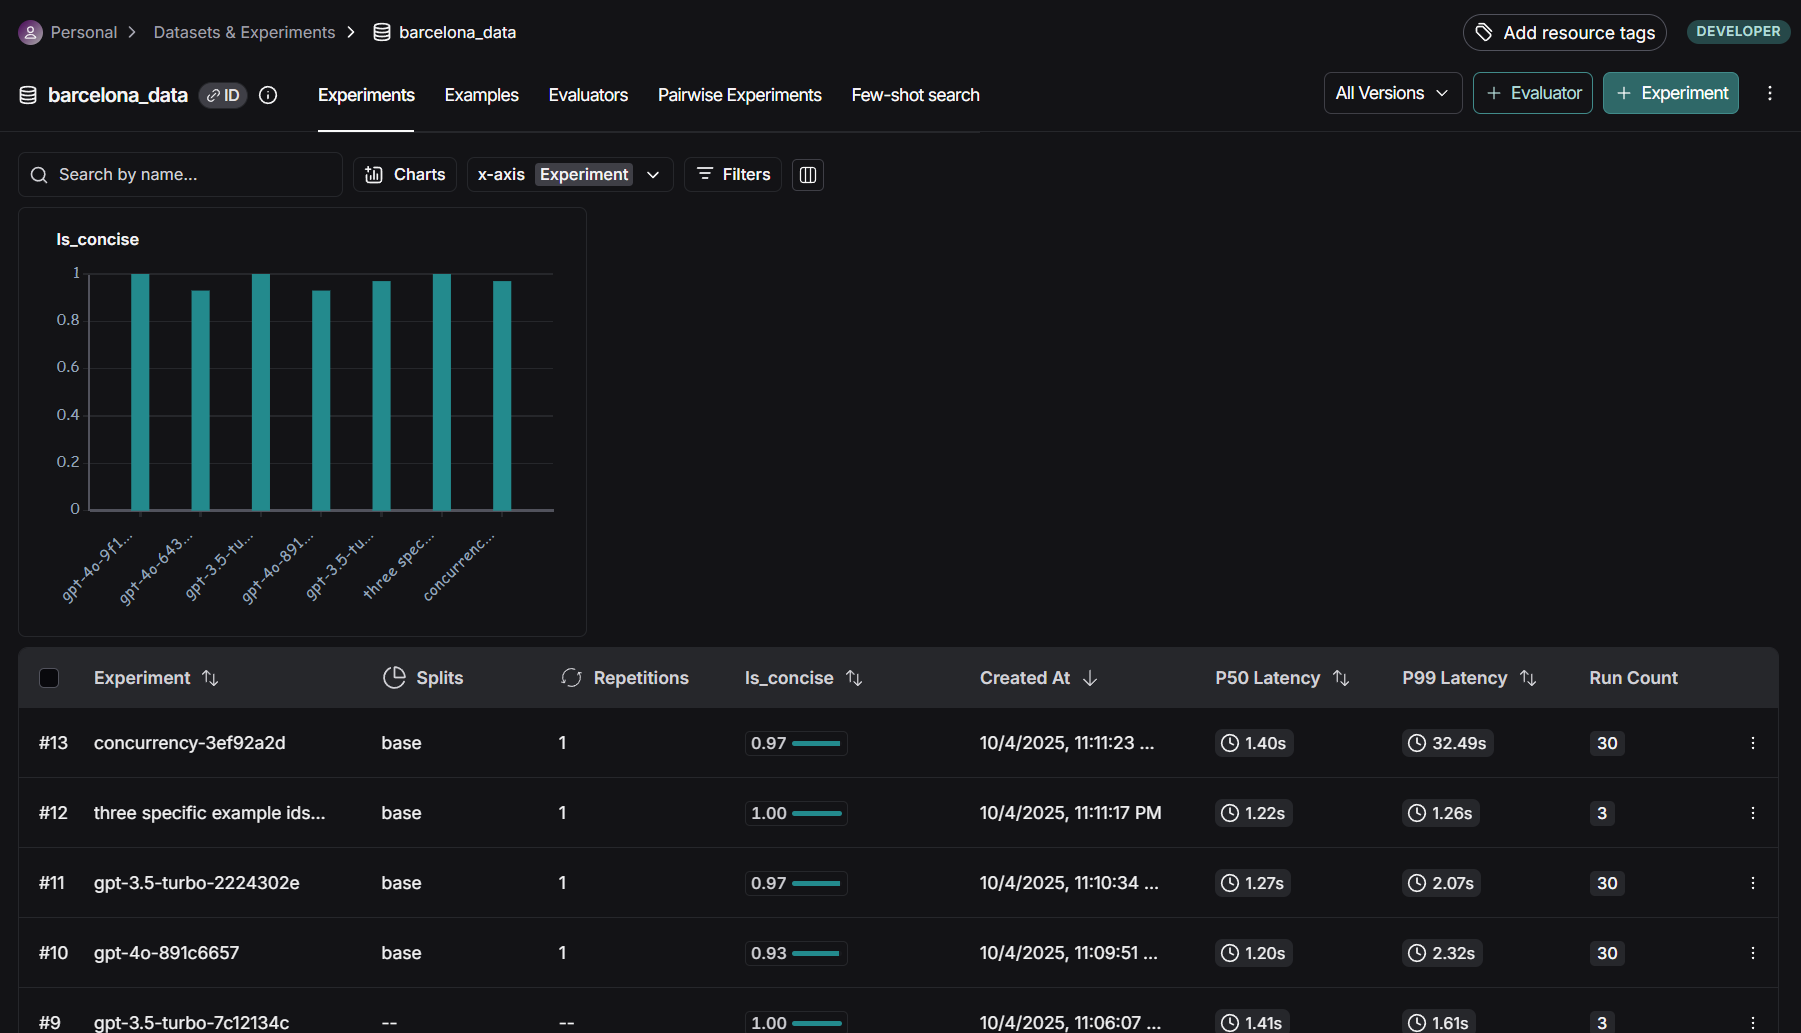